https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=at-h4OWK0aoc


In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ft03nlh6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ft03nlh6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265584 sha256=25125ad495f95261ee049fdc410d0bfc7c98100538e21905f6ecb24035a1425e
  Stored in directory: /tmp/pip-ephem-wheel-cache-t39nq8kq/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Google drive needs to have a folder 'Mask_R_CNN_demo'


Mounted at /content/gdrive


In [3]:
%%shell

cd /content/gdrive/MyDrive/Tow_plane_tracking
ls

data  pytorch_utils  script_convert_masks.py  towplane_tracking_TRAIN_v1.ipynb


In [4]:
base_dir = '/content/gdrive/MyDrive/Tow_plane_tracking'

In [5]:
from PIL import Image
import os

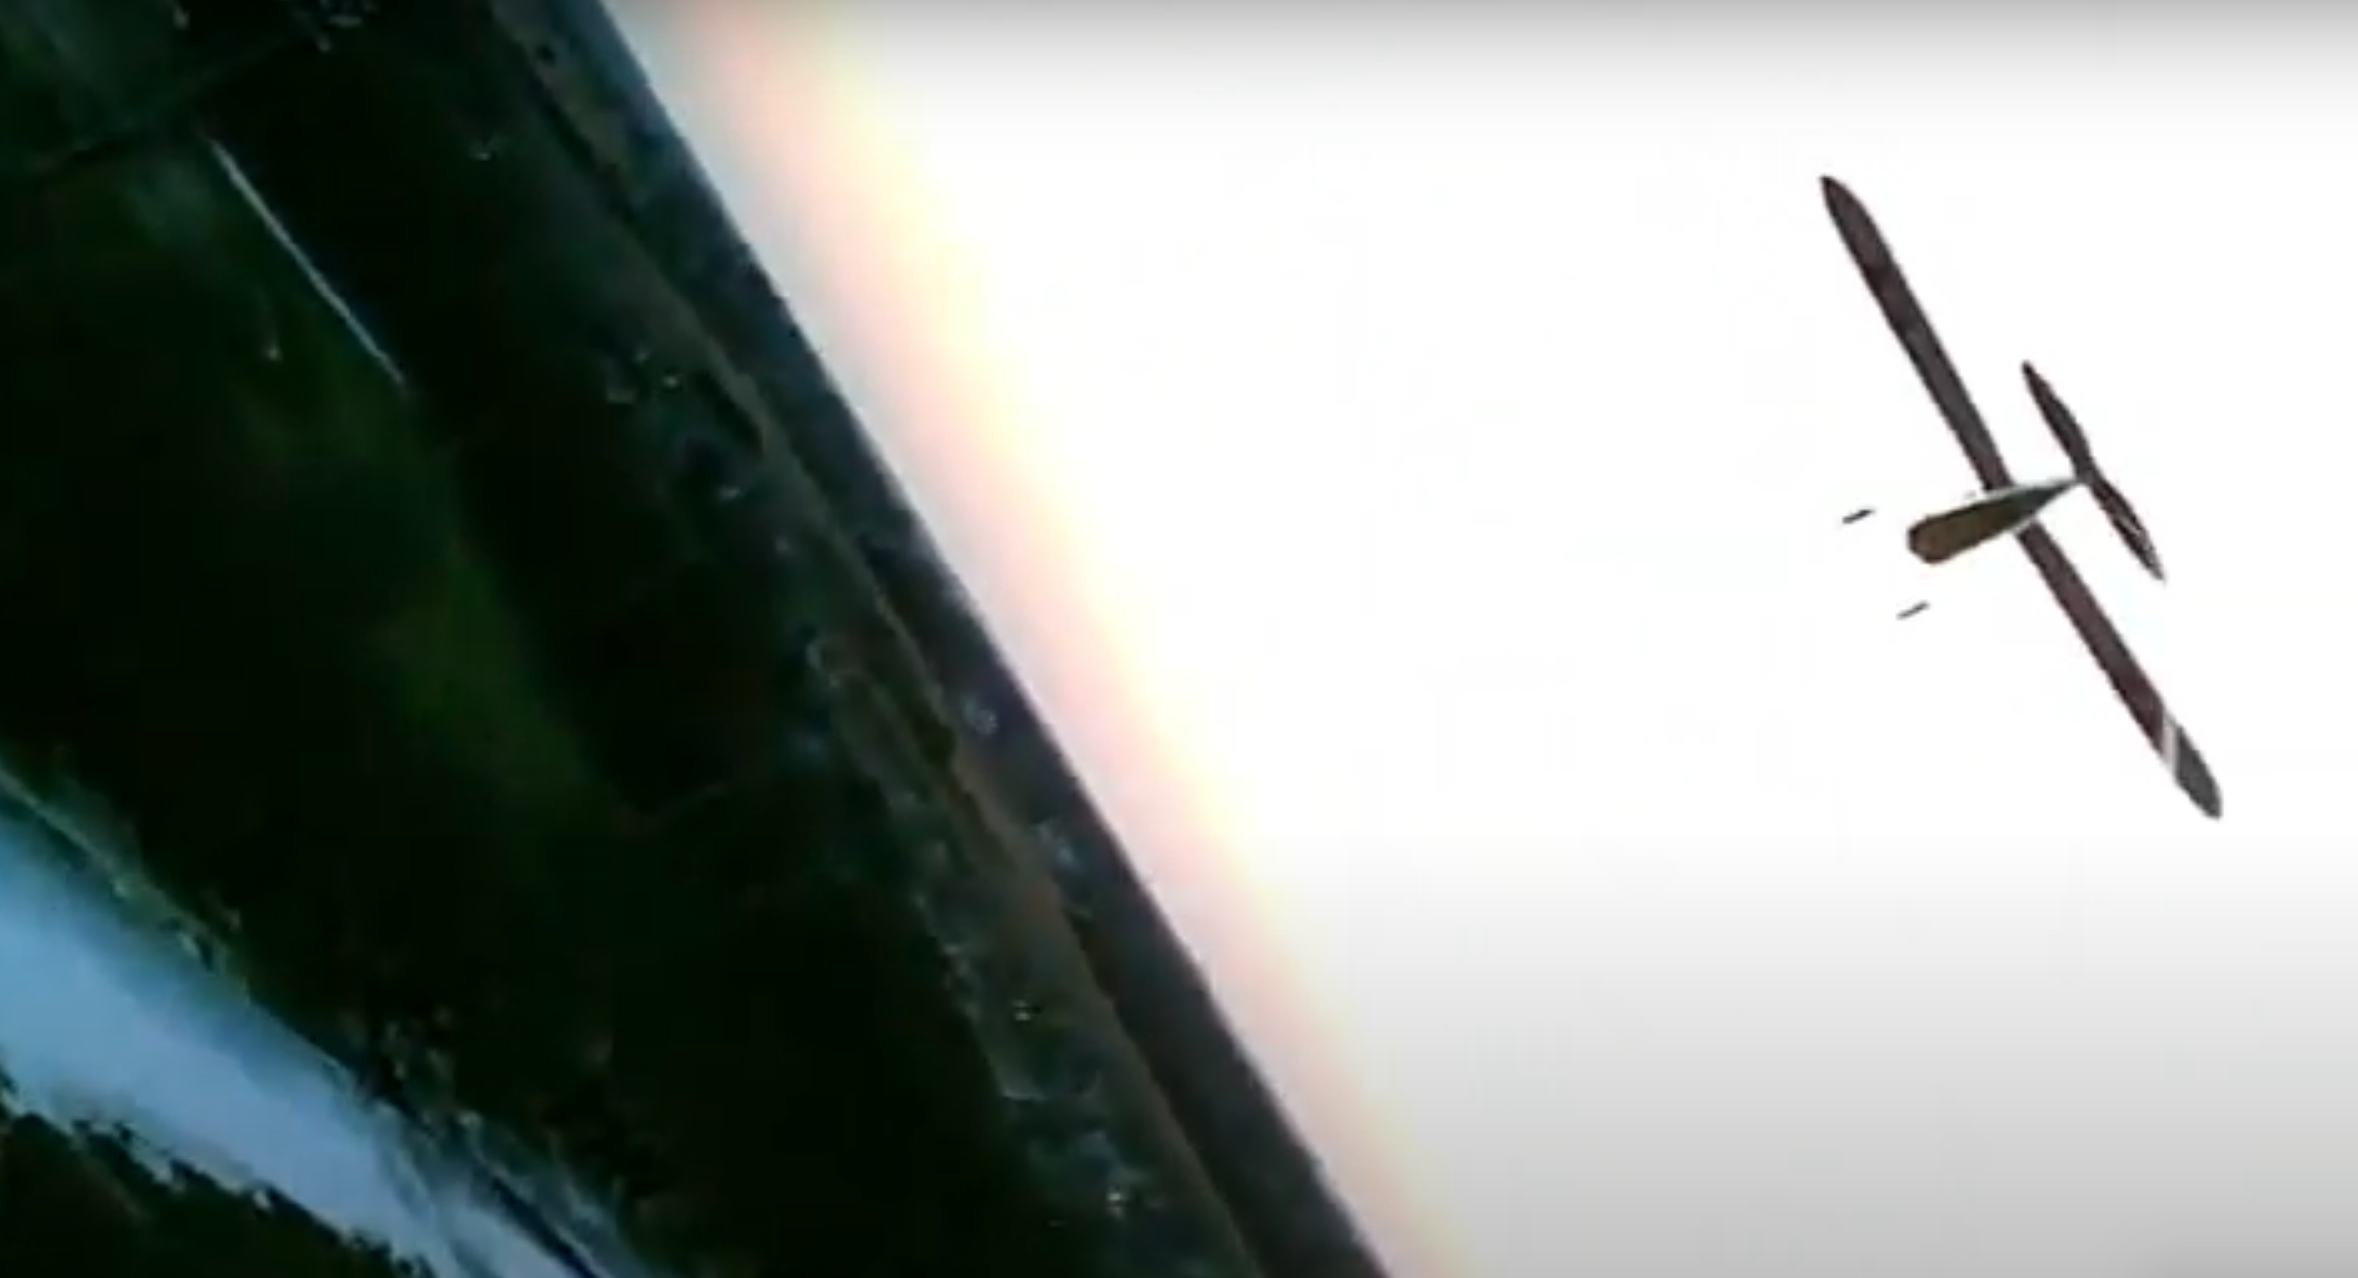

In [6]:
Image.open(os.path.join(base_dir, 'data', 'images_cleaned/img_0.png'))

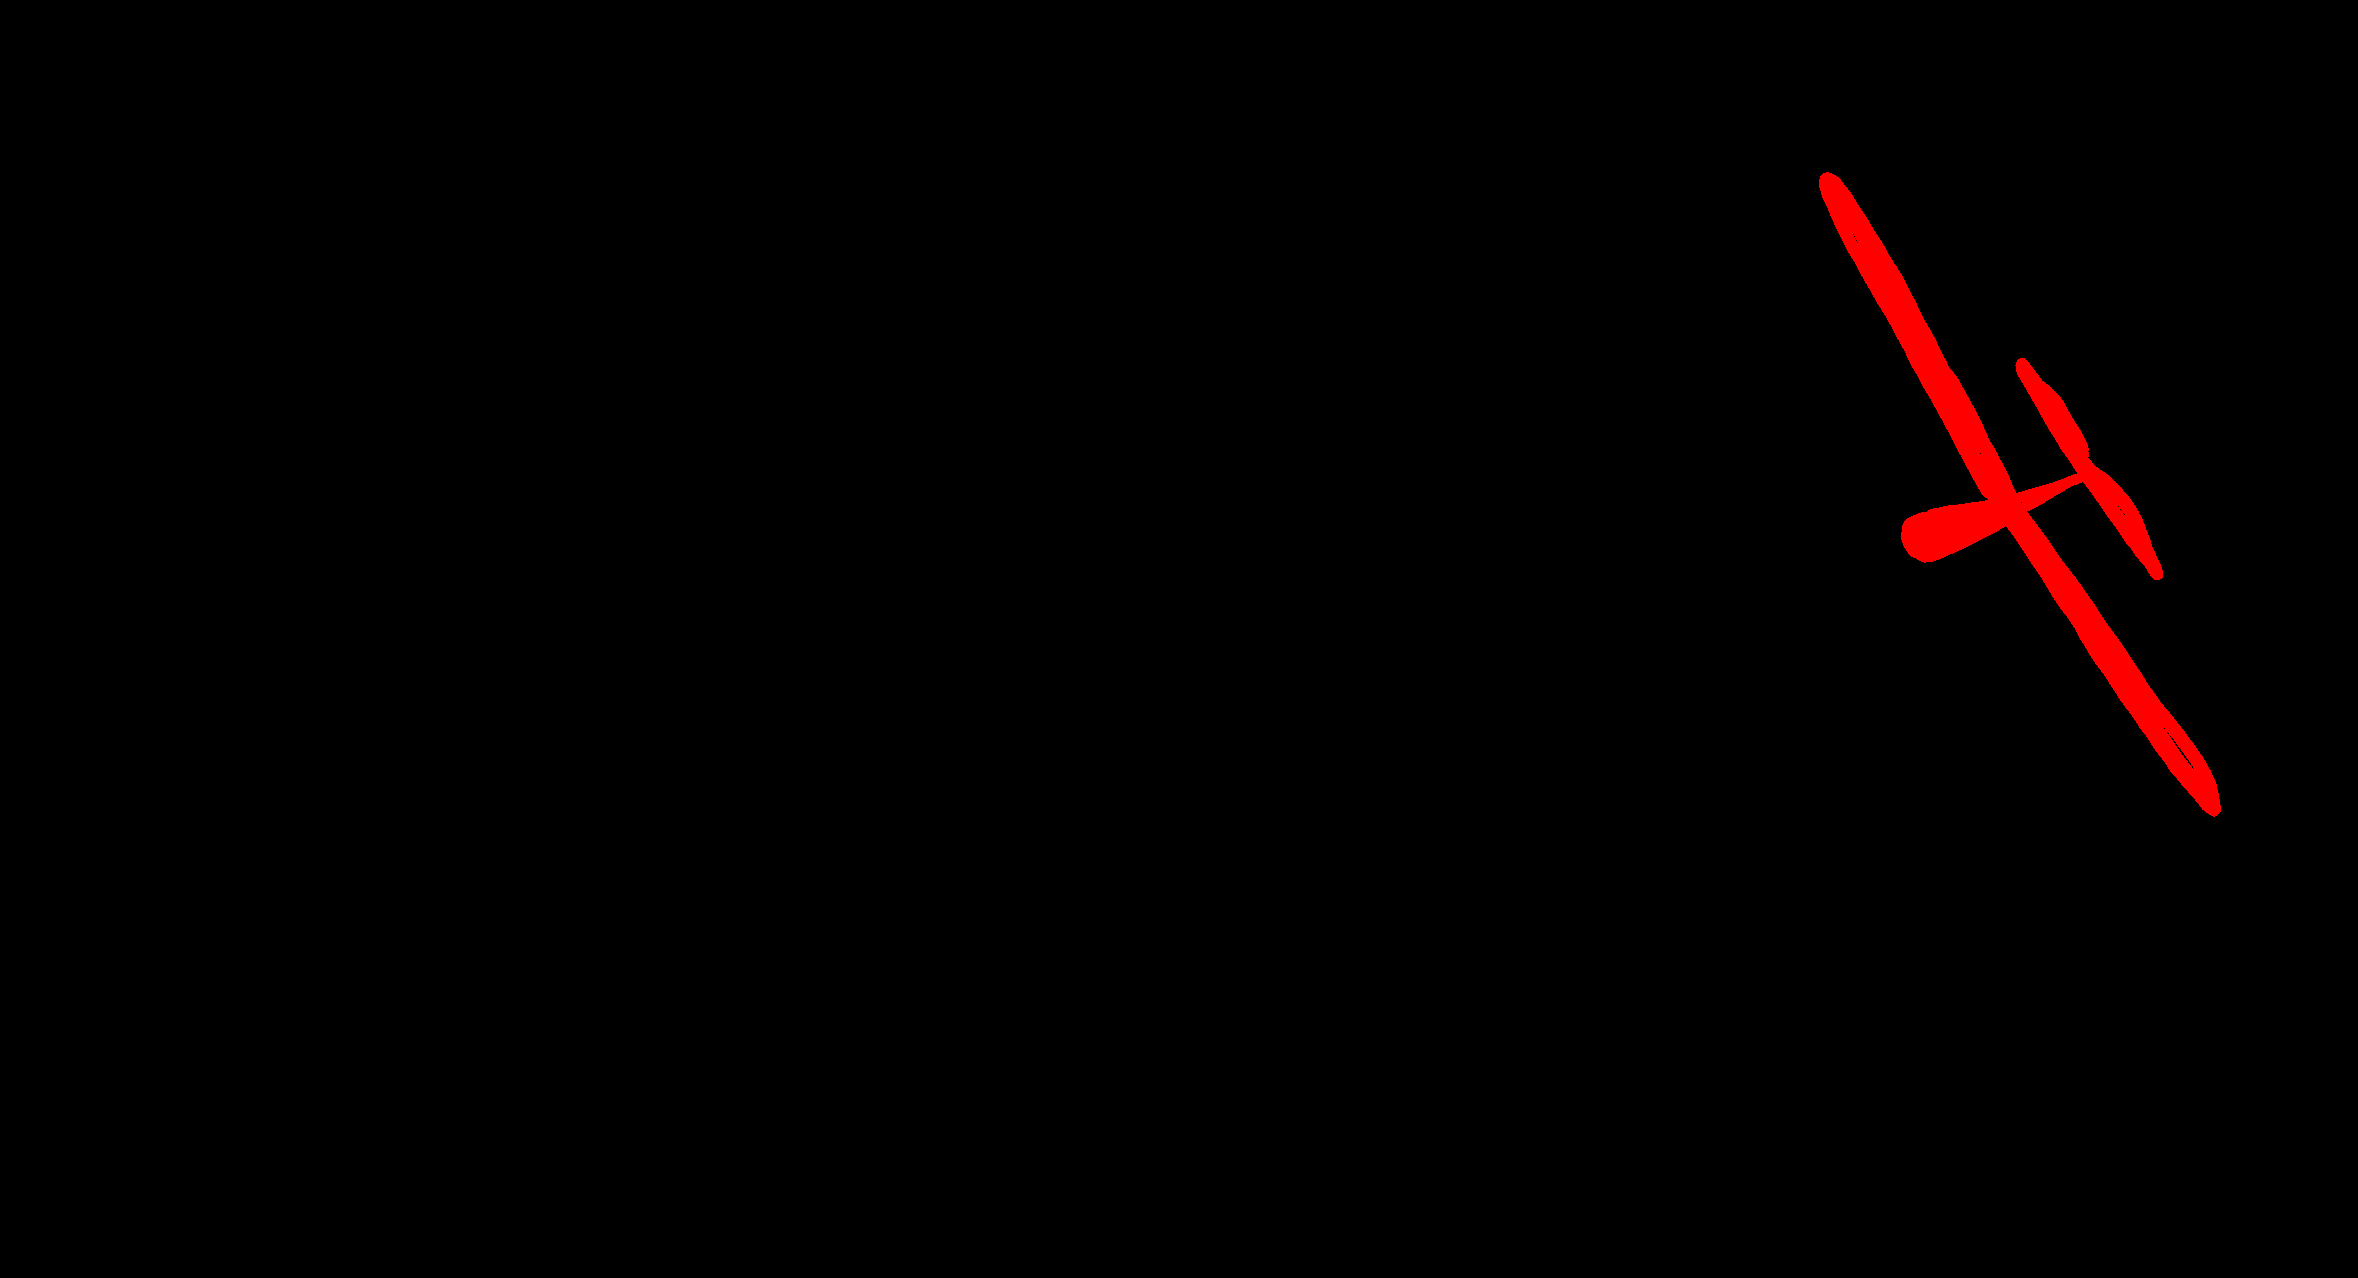

In [7]:
mask = Image.open(os.path.join(base_dir, 'data', 'masks_cleaned/mask_0.png'))
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0 # index 1 is red
])
mask

In [8]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class TowplaneDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images_cleaned"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks_cleaned"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images_cleaned", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks_cleaned", self.masks[idx])
        #print('- ', img_path, '    ', mask_path)
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def __getdebuginfo__(self, idx):
      img_path = os.path.join(self.root, "images_cleaned", self.imgs[idx])
      mask_path = os.path.join(self.root, "masks_cleaned", self.masks[idx])
      return img_path, mask_path



In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
# change current working directory of python 
import sys
import os

for p in sys.path:
  print(p)

print("cwd: ", os.getcwd())
os.chdir('/content/gdrive/MyDrive/Tow_plane_tracking') 
print("cwd: ", os.getcwd())





/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
cwd:  /content
cwd:  /content/gdrive/MyDrive/Tow_plane_tracking


In [11]:
from pytorch_utils.engine import train_one_epoch, evaluate
import pytorch_utils.utils as utils
import pytorch_utils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
# use our dataset and defined transformations
dataset = TowplaneDataset('data', get_transform(train=True))
dataset_test = TowplaneDataset('data', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
for idx in range(dataset.__len__()):
  print("  " + str(idx))
  image, targets = dataset.__getitem__(idx)


In [18]:
image, mask = dataset.__getdebuginfo__(80)
print(image)
print(mask)
 

data/images_cleaned/img_170.png
data/masks_cleaned/mask_170.png


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [14]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Streaming output truncated to the last 5000 lines.
Epoch: [0]  [120/219]  eta: 0:01:33  lr: 0.002777  loss: 0.3566 (0.6325)  loss_classifier: 0.0317 (0.1082)  loss_box_reg: 0.0884 (0.0907)  loss_mask: 0.2119 (0.4135)  loss_objectness: 0.0006 (0.0138)  loss_rpn_box_reg: 0.0027 (0.0063)  time: 0.9401  data: 0.6241  max mem: 1726
Epoch: [0]  [121/219]  eta: 0:01:32  lr: 0.002800  loss: 0.3591 (0.6305)  loss_classifier: 0.0317 (0.1077)  loss_box_reg: 0.0870 (0.0905)  loss_mask: 0.2219 (0.4123)  loss_objectness: 0.0006 (0.0137)  loss_rpn_box_reg: 0.0027 (0.0064)  time: 0.9300  data: 0.6160  max mem: 1726
Epoch: [0]  [122/219]  eta: 0:01:31  lr: 0.002823  loss: 0.3591 (0.6275)  loss_classifier: 0.0310 (0.1070)  loss_box_reg: 0.0868 (0.0902)  loss_mask: 0.2219 (0.4103)  loss_objectness: 0.0005 (0.0136)  loss_rpn_box_reg: 0.0027 (0.0064)  time: 0.8981  data: 0.5841  max mem: 1726
Epoch: [0]  [123/219]  eta: 0:01:30  lr: 0.002846  loss: 0.3566 (0.6253)  loss_classifier: 0.0310 (0.1064)  loss_bo

In [56]:
# save model's state dictionary to google drive

torch.save(model.state_dict(), os.path.join(base_dir, 'model_state/model_state_dict.pt'))
torch.save(optimizer.state_dict(), os.path.join(base_dir, 'model_state/optimizer_state_dict.pt'))

In [69]:
# pick one image from the test set
img, _ = dataset_test[19]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

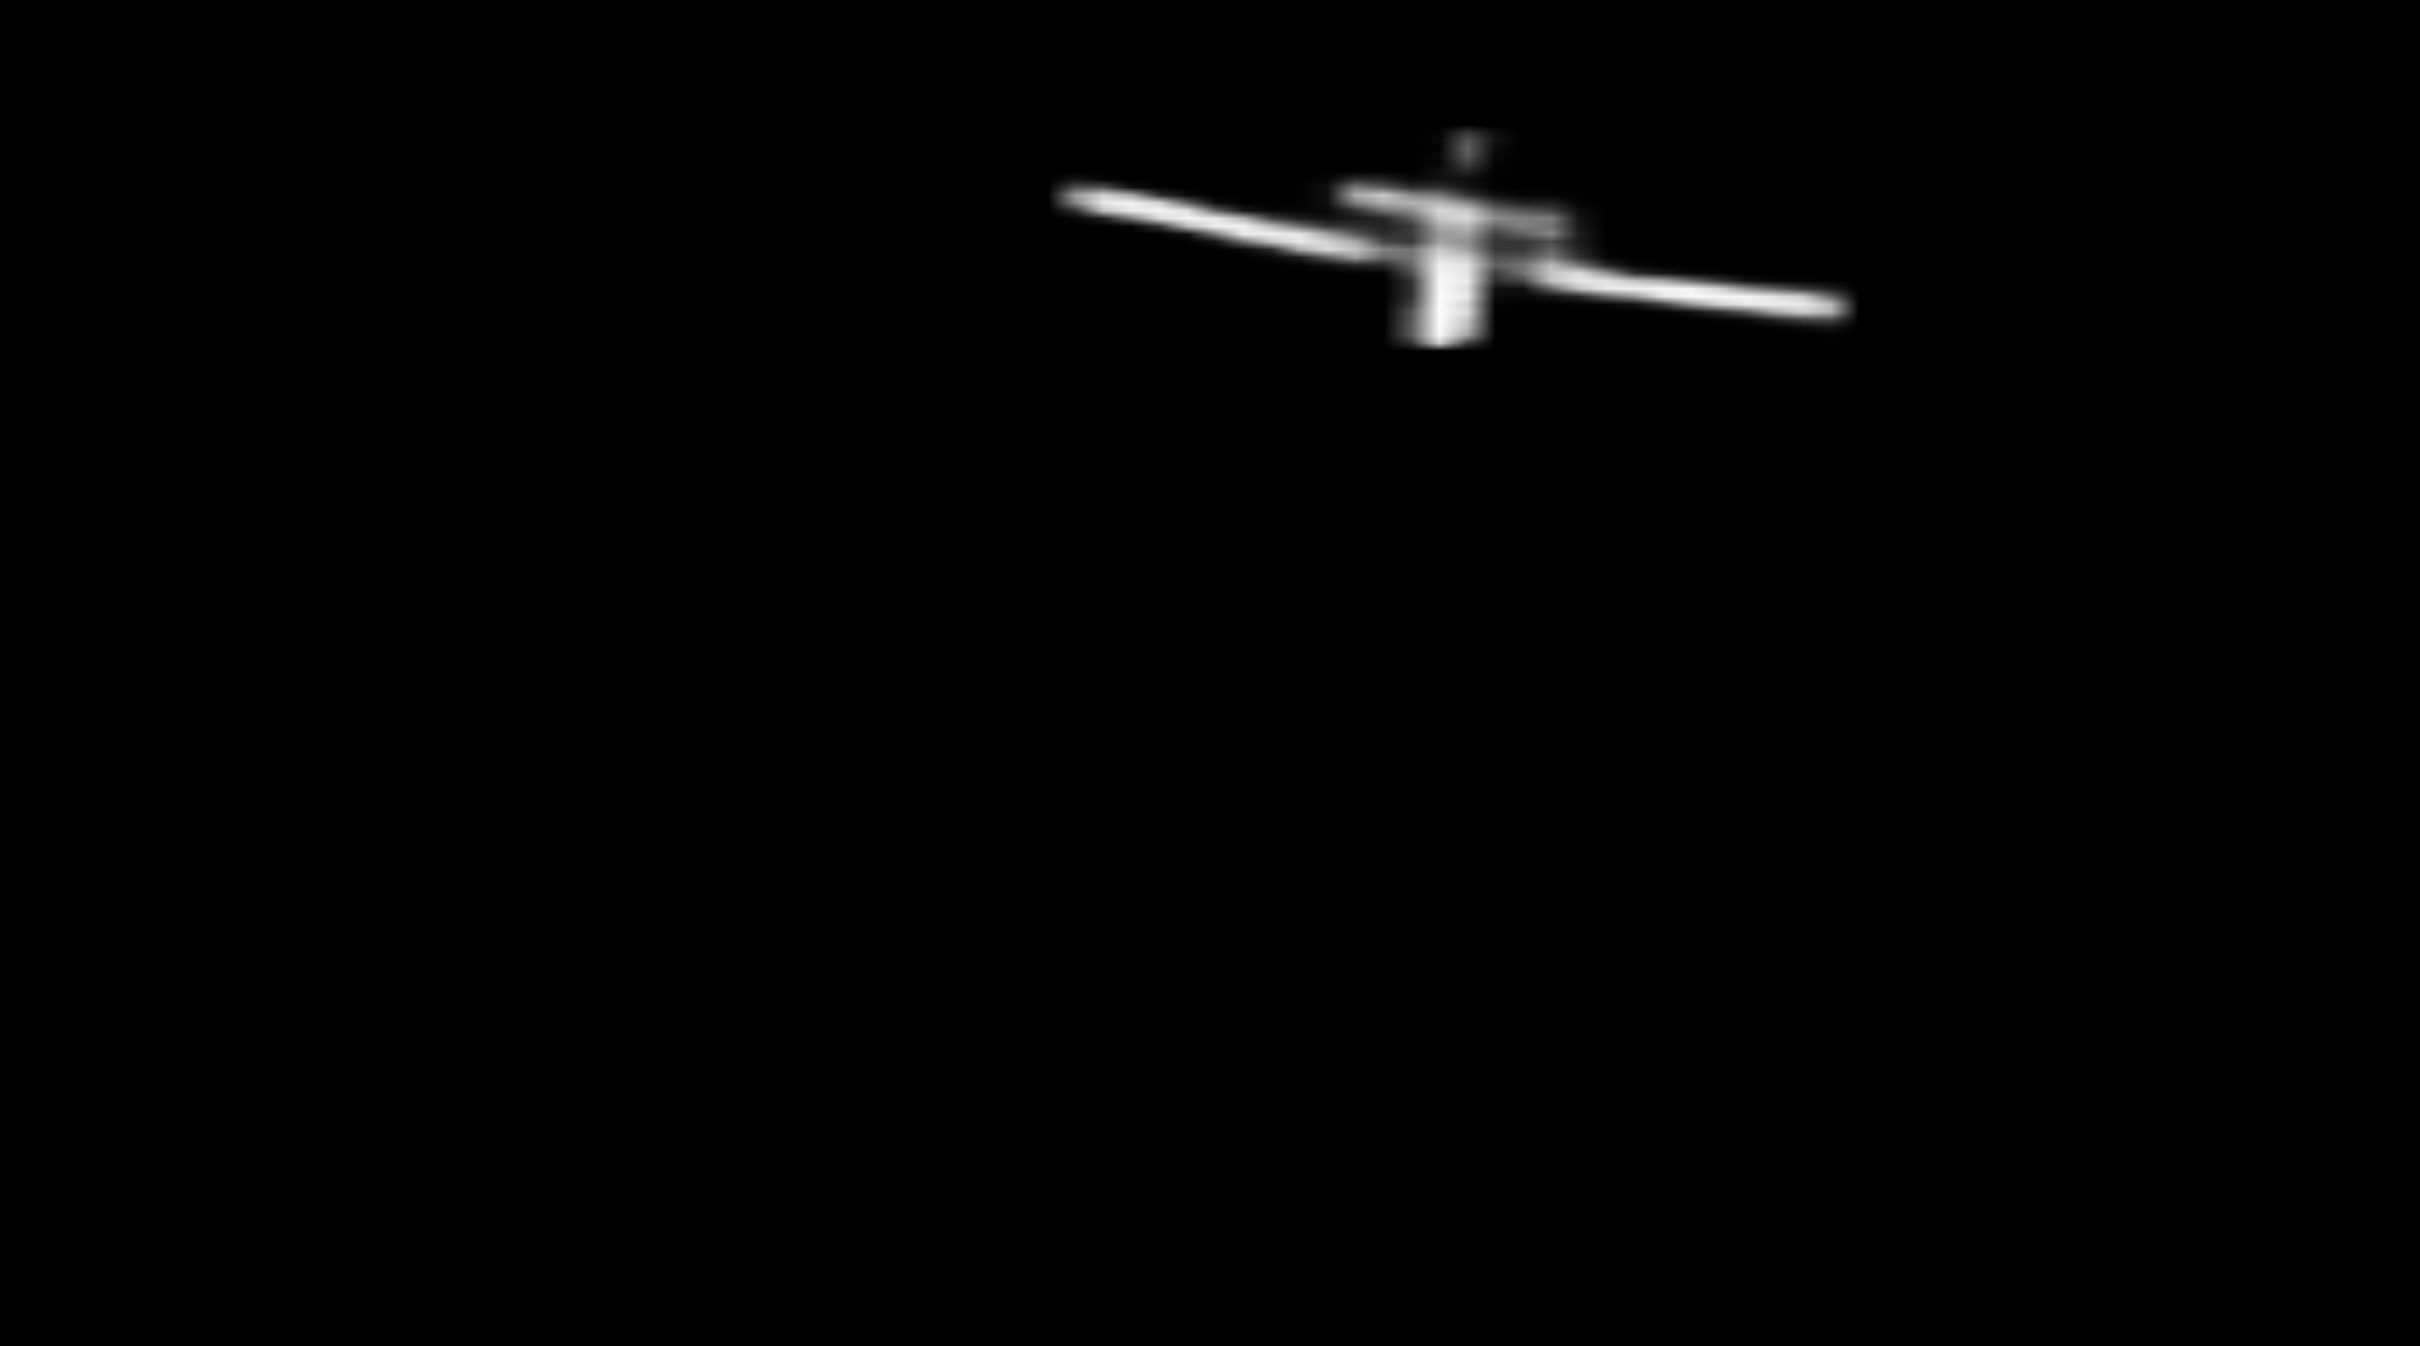

In [70]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

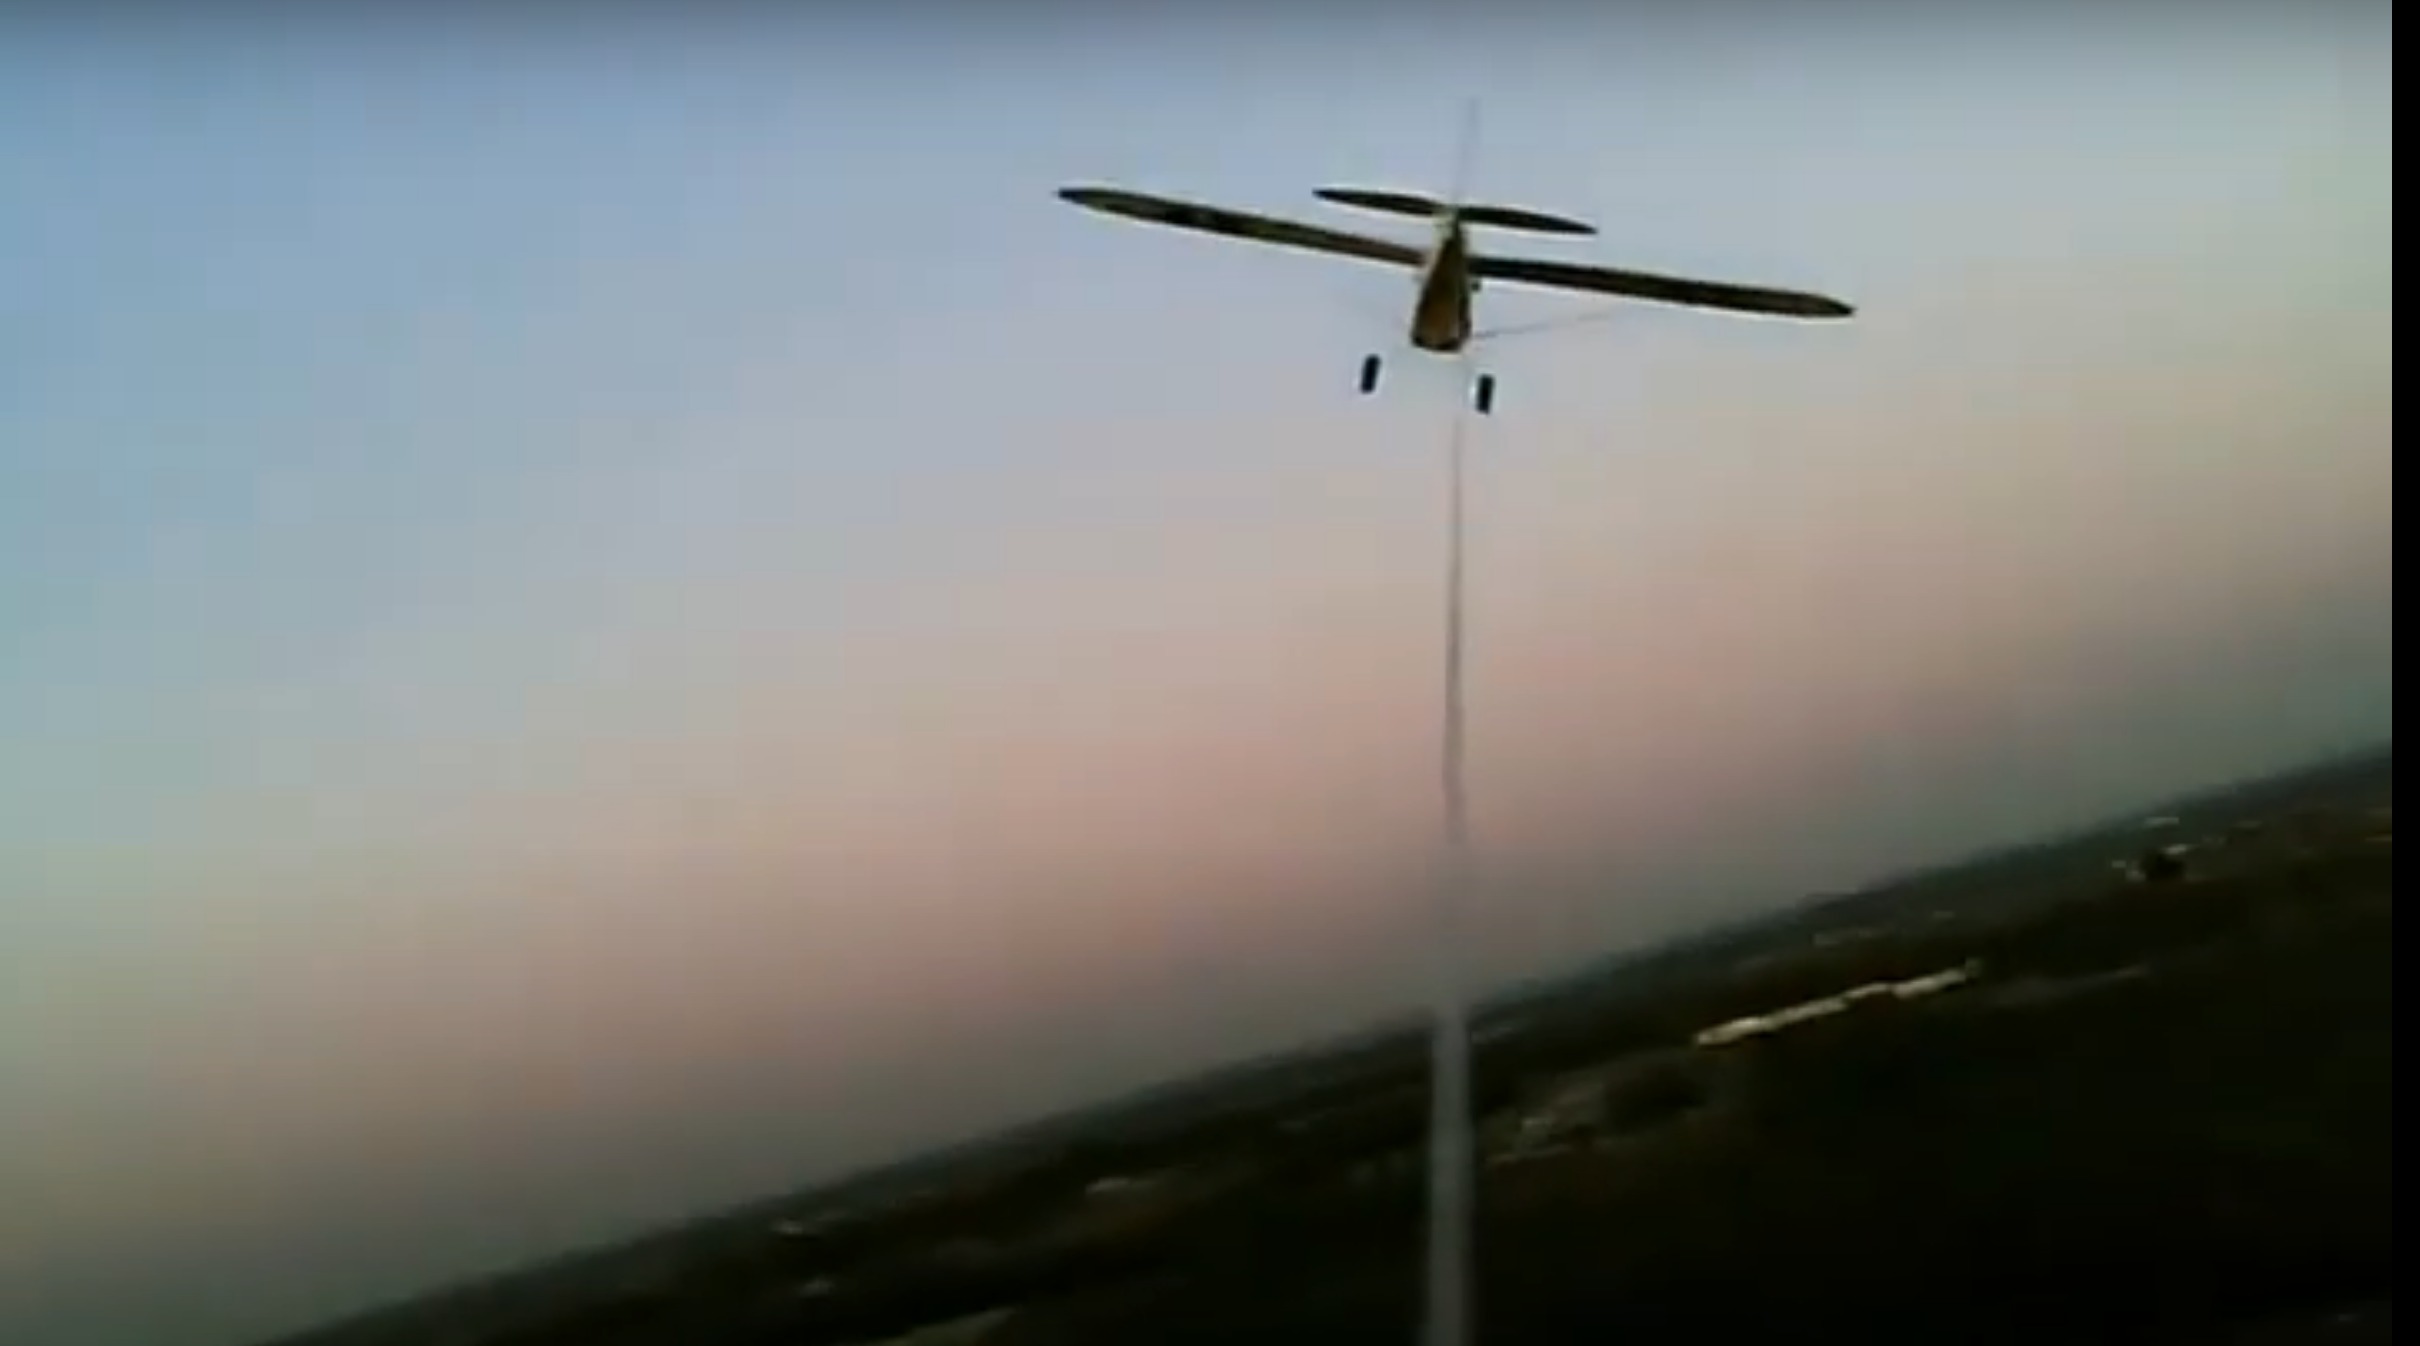

In [71]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())